In [1]:
import pandas as pd
import numpy as np
import os
import sys
import datetime
import time
import math
import netCDF4 as nc

#from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler,Normalizer
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score, r2_score
from sklearn.feature_selection import mutual_info_regression

import matplotlib.dates as mdates
import matplotlib.colors
import matplotlib.ticker as ticker

from pysolar.solar import *
import pytz
import shap
import pickle
import multiprocessing

from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection

RANDOM_STATE = 42
n_jobs = multiprocessing.cpu_count()
#  32.5,  33.5
# -97.5, -96.5

In [2]:
folder = "spatial"
node_id = "10004098"
dir_out = "../figures/" + folder + "/"
dir_data = "../data/"

fn_in = dir_data + "driving_" + node_id + "_landsat_NEXRAD.csv"


In [3]:
df = pd.read_csv(fn_in, index_col = 'UTC')

In [4]:
features = ['Zenith',
            'SR1', 'SR2', 'SR3', 'SR4',
            'reflectivity 0km', 'reflectivity 1km',
            'reflectivity 2km', 'reflectivity 3km', 'reflectivity 4km',
            'reflectivity 5km', 'reflectivity 6km', 'reflectivity 7km',
            'reflectivity 8km', 'reflectivity 9km', 'reflectivity 10km',
            'velocity 0km', 'velocity 1km', 'velocity 2km', 'velocity 3km',
            'velocity 4km', 'velocity 5km', 'velocity 6km', 'velocity 7km',
            'velocity 8km', 'velocity 9km', 'velocity 10km', 'spectrum_width 0km',
            'spectrum_width 1km', 'spectrum_width 2km', 'spectrum_width 3km',
            'spectrum_width 4km', 'spectrum_width 5km', 'spectrum_width 6km',
            'spectrum_width 7km', 'spectrum_width 8km', 'spectrum_width 9km',
            'spectrum_width 10km', 'differential_phase 0km',
            'differential_phase 1km', 'differential_phase 2km',
            'differential_phase 3km', 'differential_phase 4km',
            'differential_phase 5km', 'differential_phase 6km',
            'differential_phase 7km', 'differential_phase 8km',
            'differential_phase 9km', 'differential_phase 10km',
            'differential_reflectivity 0km', 'differential_reflectivity 1km',
            'differential_reflectivity 2km', 'differential_reflectivity 3km',
            'differential_reflectivity 4km', 'differential_reflectivity 5km',
            'differential_reflectivity 6km', 'differential_reflectivity 7km',
            'differential_reflectivity 8km', 'differential_reflectivity 9km',
            'differential_reflectivity 10km', 'cross_correlation_ratio 0km',
            'cross_correlation_ratio 1km', 'cross_correlation_ratio 2km',
            'cross_correlation_ratio 3km', 'cross_correlation_ratio 4km',
            'cross_correlation_ratio 5km', 'cross_correlation_ratio 6km',
            'cross_correlation_ratio 7km', 'cross_correlation_ratio 8km',
            'cross_correlation_ratio 9km', 'cross_correlation_ratio 10km',
            'ROI 0km', 'ROI 1km', 'ROI 2km', 'ROI 3km', 'ROI 4km', 'ROI 5km',
            'ROI 6km', 'ROI 7km', 'ROI 8km', 'ROI 9km', 'ROI 10km']

target = 'Illuminance'

In [5]:
X = df[features]
y = df[[target]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 

In [6]:
# scale the data
scaler_x = MinMaxScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)


In [7]:
n_components = 64

DR = 'PCA'
Cluster = 'None'
pca = PCA(n_components=n_components, random_state = RANDOM_STATE)

X_train_scaled_DR = pca.fit_transform(X_train_scaled)
X_test_scaled_DR = pca.transform(X_test_scaled)

print(pca.explained_variance_)


[1.22426047e+00 1.79782271e-01 1.12338336e-01 4.87117314e-02
 3.65987535e-02 2.87768513e-02 2.50026671e-02 1.83304988e-02
 1.48054681e-02 1.40164165e-02 9.82502529e-03 9.51752420e-03
 7.90408416e-03 5.98610103e-03 5.20231571e-03 3.44914064e-03
 3.25966528e-03 3.05979221e-03 2.86596164e-03 1.97596230e-03
 1.85014626e-03 1.61905097e-03 1.55098249e-03 1.46546335e-03
 1.34471404e-03 9.42783821e-04 8.71147327e-04 8.39768327e-04
 6.16878903e-04 5.34854764e-04 5.05156592e-04 4.59869483e-04
 3.94476208e-04 3.32535954e-04 3.02183558e-04 2.37868820e-04
 1.70257017e-04 1.65206717e-04 1.36842638e-04 1.23583372e-04
 8.36426366e-05 6.60436466e-05 4.02764960e-05 3.44450923e-05
 3.10821625e-05 2.53982908e-05 1.42860434e-05 9.45532782e-06
 7.91738713e-06 2.66887663e-06 1.21007683e-06 2.60249045e-07
 1.76712410e-07 1.04527327e-07 6.53037525e-08 5.66788384e-08
 3.05203447e-08 1.50301998e-08 1.45521689e-08 9.15831206e-09
 7.47720771e-09 3.88710420e-09 1.03401835e-09 1.63233963e-10]


In [8]:
scaler_x2 = StandardScaler()
X_train_scaled_DR_scaled = scaler_x2.fit_transform(X_train_scaled_DR)
X_test_scaled_DR_scaled = scaler_x2.transform(X_test_scaled_DR)

In [87]:
# start_time = time.time()

# hidden_layer_sizes = []
# for i in range(10,500,10):
#     hidden_layer_sizes.append([i])
# activation ='relu'
# solver = 'adam'
# alpha=1e-5 #L2 penalty (regularization term) parameter
# # NN Model, grid search to find best parameter
# regr = MLPRegressor(random_state = RANDOM_STATE,
#                    activation = activation,
#                    solver=solver,
#                    alpha=alpha)

# param_grid = {'hidden_layer_sizes': hidden_layer_sizes}
# CV_regr = GridSearchCV(estimator = regr, param_grid = param_grid, cv =5, verbose = 3)#, n_jobs = n_jobs)

# length_sample = len(X_train_scaled)//10
# CV_regr.fit(X_train_scaled_DR_scaled[:length_sample], y_train_scaled[:length_sample].flatten())
# print(CV_regr.best_params_)
# print(CV_regr.best_score_)

# print("--- %s seconds ---" % (time.time() - start_time))

In [9]:
#hidden_layer_sizes=(32,64,128)
# hidden_layer_sizes=(64,128,256)#
# hidden_layer_sizes=(256,256,256,256)
hidden_layer_sizes=(128,128,128,128,128)
#hidden_layer_sizes=(150)
activation ='relu'
solver = 'adam'
alpha=1e-5 # L2 penalty (regularization term) parameter, default 1e-5
learning_rate = 'constant'

# include layer structure and activation function
structure = '_' + DR + str(n_components) + \
            '_' + str(hidden_layer_sizes)[1:-1].replace(', ','_') + \
            '_' + activation

In [10]:
start_time = time.time()

regr = MLPRegressor(random_state = RANDOM_STATE,
                    hidden_layer_sizes = hidden_layer_sizes,
                    activation = activation,
                    solver = solver,
                    alpha = alpha,
                    learning_rate = learning_rate,
                    verbose = True
                    )
regr.fit(X_train_scaled_DR_scaled, y_train_scaled)

# # fine tune the model
# regr.warm_start = True
# regr.learning_rate_init /= 10 # default 0.001
# regr.fit(X_train_scaled_DR_scaled, y_train_scaled)

# regr.learning_rate_init /= 10 # default 0.001
# regr.fit(X_train_scaled_DR_scaled, y_train_scaled)

print("--- %s seconds ---" % (time.time() - start_time))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Iteration 1, loss = 0.19318871
Iteration 2, loss = 0.13632253
Iteration 3, loss = 0.12768018
Iteration 4, loss = 0.11780786
Iteration 5, loss = 0.11421766
Iteration 6, loss = 0.11059946
Iteration 7, loss = 0.10594125
Iteration 8, loss = 0.10185287
Iteration 9, loss = 0.09636237
Iteration 10, loss = 0.09511003
Iteration 11, loss = 0.09224360
Iteration 12, loss = 0.09174034
Iteration 13, loss = 0.08861759
Iteration 14, loss = 0.08327025
Iteration 15, loss = 0.08406264
Iteration 16, loss = 0.08068815
Iteration 17, loss = 0.07691086
Iteration 18, loss = 0.07843715
Iteration 19, loss = 0.07546054
Iteration 20, loss = 0.07553412
Iteration 21, loss = 0.07257630
Iteration 22, loss = 0.06821637
Iteration 23, loss = 0.06985600
Iteration 24, loss = 0.07052520
Iteration 25, loss = 0.06754312
Iteration 26, loss = 0.06175531
Iteration 27, loss = 0.06600394
Iteration 28, loss = 0.06206175
Iteration 29, loss = 0.06393538
Iteration 30, loss = 0.06638664
Iteration 31, loss = 0.05712468
Iteration 32, los

In [11]:
fn_model = '../models/spatial_MLP_' + target + structure + '.sav'
pickle.dump(regr, open(fn_model, 'wb'))


In [19]:
y_min, y_mean + 5*y_std

(0,
 Illuminance    25818.666132
 dtype: float64)

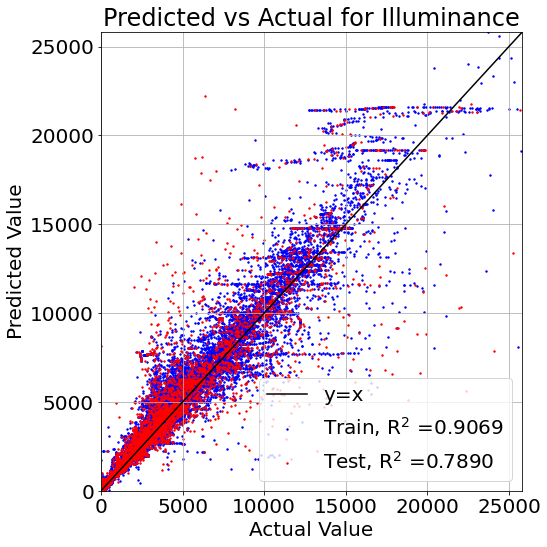

In [20]:
y_train_pred = scaler_y.inverse_transform(\
                    regr.predict( X_train_scaled_DR_scaled ).reshape(-1,1)
                    ) # for train
y_test_pred = scaler_y.inverse_transform(\
                    regr.predict( X_test_scaled_DR_scaled ).reshape(-1,1)
                    ) # for image

train_score =  r2_score(y_train, y_train_pred)
test_score = r2_score(y_test, y_test_pred)

y_min = 0 # np.amin(y_train.values)
y_max = np.amax(y_train.values)
y_mean = np.mean(y_train.values)
y_std = np.std(y_train.values)
y_line = np.linspace(y_min,y_max,100)

plt.rcParams["figure.figsize"] = (8, 8) # (w, h)
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots()
plt.plot(y_line,y_line, '-k', label='y=x')
plt.scatter(y_train,y_train_pred, s=2, c = 'blue',label = 'Train, R$^{2}$ ='+str(train_score)[:6])
plt.scatter(y_test,y_test_pred, s=2, c = 'red', label = 'Test, R$^{2}$ ='+str(test_score)[:6])
plt.xlim((y_min, y_mean + 5*y_std))
plt.ylim((y_min, y_mean + 5*y_std))
ax.set_title('Predicted vs Actual for ' + target)
ax.set_xlabel('Actual Value')
ax.set_ylabel('Predicted Value')
plt.legend( loc='lower right')
plt.grid()
plt.tight_layout()

if not os.path.exists(dir_out + target):
    os.mkdir(dir_out + target)
plt.savefig(dir_out + target +'/spatial_MLP_performance_'+target+structure+'.png')


In [27]:
# Create object that can calculate shap values
num_shap = 100
X_sample = shap.sample(X_train_scaled_DR_scaled, num_shap)
explainer = shap.KernelExplainer(regr.predict, X_sample)
# Calculate shap_values
shap_values = explainer.shap_values(X_sample)

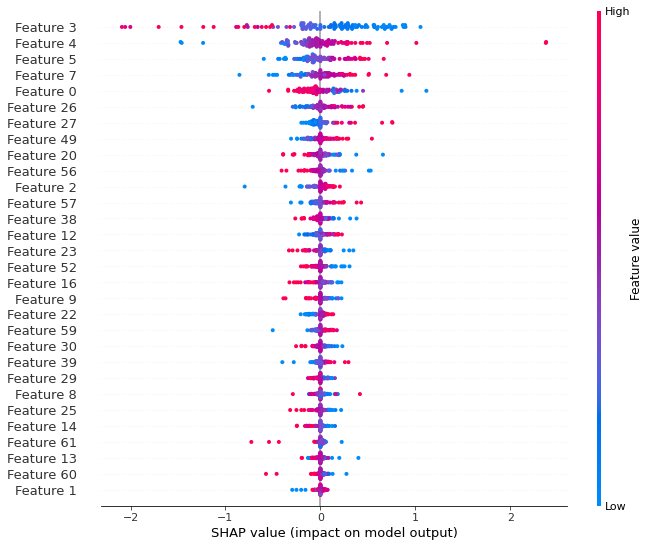

In [28]:
# plot
shap.summary_plot(shap_values, X_sample,
                  plot_size=(10,8),#'auto'
                  max_display = 30,
                  show=False
                 )
plt.tight_layout()
plt.savefig(dir_out + target + '/spatial_RF_shap_'+ target +'.png')